## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse

import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
DATAFILE = '../ad_campaign_data.csv' # location of dataset
random_state = None # change to something for exactly reproducible results

# as selected in "tutorial_bias_advertising" notebook
selected_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated', 'homeowner']
cate_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated']
num_features = ['homeowner']

# if not specified, set to 1
feature_weights = {"gender": 1, "parents": 1, "age": 1}

target_name = "true_conversion"
positive_label = 1
negative_label = 0

model_train_fraction = 0.7
learning_class_weights = {0: 0.5, 1: 265}

sensitive_attribute = "gender"

## Load Dataset

In [3]:
ad_conversion_dataset = pd.read_csv(DATAFILE)
ad_conversion_dataset.head()

,religion,politics,college_educated,parents,homeowner,gender,age,income,area,true_conversion,predicted_conversion,predicted_probability
0,Unknown,Unknown,1,1,1,Unknown,55-64,Unknown,Unknown,0,0,0.001351
1,Other,Unknown,1,1,1,Unknown,55-64,Unknown,Urban,0,0,0.002238
2,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.002704
3,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.001967
4,Unknown,Unknown,1,1,1,F,55-64,Unknown,Urban,0,0,0.001681


### Print some statistics for the dataset

In [4]:
print(f"Number of (instances, attributes) in the dataset = {ad_conversion_dataset.shape}")
print()

print(f"Statistics of true conversions (0=no, 1=yes)")
print(ad_conversion_dataset.true_conversion.value_counts())
print()

print(f"Statistics of predicted conversions (0=no, 1=yes)")
print(ad_conversion_dataset.predicted_conversion.value_counts())

Number of (instances, attributes) in the dataset = (1443140, 12)

Statistics of true conversions (0=no, 1=yes)
0    1440766
1       2374
Name: true_conversion, dtype: int64

Statistics of predicted conversions (0=no, 1=yes)
0    1440773
1       2367
Name: predicted_conversion, dtype: int64


### Warning!

There is no model!

Predictions (from whatever model has been used) have been incorporated into the dataset, in the columns "predicted_conversion" (which is the predicted label) and "predicted_probability" (which is the predicted probability of belonging to the positive class).

Moreover, the dataset is highly unbalanced, and this is also evident in the poor efficiency of the model, as demonstrated in the confusion matrix below.

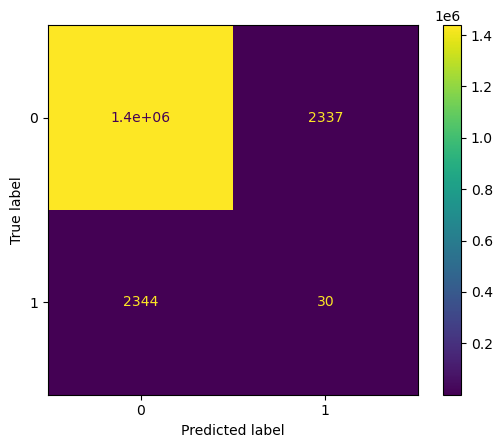

In [5]:
conf_matrix = confusion_matrix(ad_conversion_dataset.true_conversion, ad_conversion_dataset.predicted_conversion)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Preprocessing

In [6]:
## keep only the columns in selected_features, plus the label column
ad_conversion_dataset = ad_conversion_dataset[selected_features + [target_name]]
ad_conversion_dataset

,gender,parents,age,income,area,college_educated,homeowner,true_conversion
0,Unknown,1,55-64,Unknown,Unknown,1,1,0
1,Unknown,1,55-64,Unknown,Urban,1,1,0
2,F,1,55-64,Unknown,Unknown,1,1,0
3,F,1,55-64,Unknown,Unknown,1,1,0
4,F,1,55-64,Unknown,Urban,1,1,0
...,...,...,...,...,...,...,...,...
1443135,F,1,25-34,Unknown,Unknown,1,1,0
1443136,F,1,55-64,Unknown,Unknown,1,0,0
1443137,Unknown,1,55-64,Unknown,Unknown,1,1,0
1443138,F,1,55-64,Unknown,Unknown,1,1,0


In [7]:
## train-test split

X = ad_conversion_dataset.drop(target_name, axis=1)
y = ad_conversion_dataset[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=model_train_fraction, random_state=random_state, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Model training

In [8]:
%%time

model = customLogisticRegression(class_weight=learning_class_weights)
model.fit(X_train, y_train, cate_columns=cate_features, target_column=target_name)
model.predict(X_test.iloc[:100, :])

CPU times: total: 3.44 s
Wall time: 5.8 s


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Testing the model

We check if the model is satisfactory.

In [9]:
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    432231
           1       0.00      0.08      0.00       712

    accuracy                           0.91    432943
   macro avg       0.50      0.50      0.48    432943
weighted avg       1.00      0.91      0.95    432943



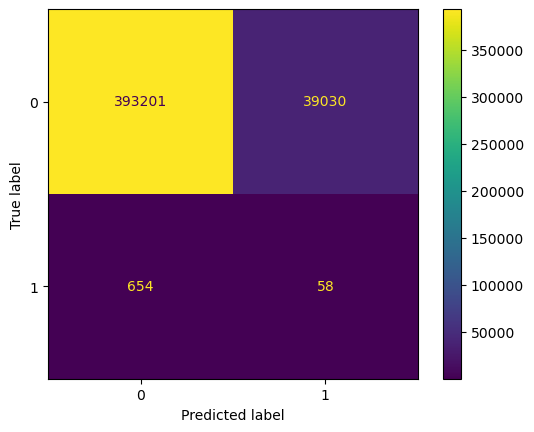

In [10]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

Given the high imbalance of the dataset, we consider that the above results, for a simple logistic regression, are good enough.

# Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [11]:
# ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model,
#     sensitive_attribute,
#     missing_subgroup_val="Unknown"
# )

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Uncomment the following block if you wish to load rules object from disk.

In [12]:
import dill

with open("rules.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [13]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["M"][1][0][1]-e[1]["F"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If college_educated = 0, parents = 1, area = Unknown, income = Unknown, homeowner = 1, age = 55-64:
	Subgroup 'F', 3.0755% covered
		Make income = <100K with correctness 0.0000%.
	Subgroup 'M', 3.0023% covered
		Make income = <100K with correctness 100.0000%.
If college_educated = 0, parents = 1, area = Unknown, income = Unknown, age = 55-64:
	Subgroup 'F', 3.0755% covered
		Make income = <100K with correctness 0.0000%.
	Subgroup 'M', 3.0023% covered
		Make income = <100K with correctness 100.0000%.
If income = <100K, parents = 1, age = 55-64, college_educated = 1:
	Subgroup 'F', 1.1214% covered
		Make age = 25-34 with correctness 0.0000%.
	Subgroup 'M', 1.1197% covered
		Make age = 25-34 with correctness 100.0000%.
If college_educated = 0, area = Unknown, income = Unknown, homeowner = 1, age = 55-64:
	Subgroup 'F', 3.2333% covered
		Make income = <100K with correctness 0.0000%.
	Subgroup 'M', 3.1829% covered
		Make income = <100K with correctness 94.3248%.
If income = <100K, parents =

In [14]:
# #### Uncomment if you wish to save rules object on disk

# import dill

# with open("rules.data", "wb") as outf:
#     dill.dump(rules_by_if, outf)

# Filter rules by different scoring functions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [15]:
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## For each if-group, inner product of then costs and correctness-es, divided by the number of terms

In [16]:
rules_max_costdiff_sorted = gfacts.sort_triples_by_max_costdiff(rules_by_if, params=params)

top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    top,
    population_sizes = {"M": (ad_conversion_dataset.gender == "M").sum(), "F": (ad_conversion_dataset.gender == "F").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If college_educated = 0, parents = 1, area = Unknown, income = Unknown, homeowner = 1, age = 55-64:
	Subgroup 'F', 3.0755% covered out of 600135
		Make income = <100K with correctness 0.0000%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'M', 3.0023% covered out of 314181
		Make income = <100K with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
If college_educated = 0, parents = 1, area = Unknown, income = Unknown, age = 55-64:
	Subgroup 'F', 3.0755% covered out of 600135
		Make income = <100K with correctness 0.0000%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'M', 3.0023% covered out of 314181
		Make income = <100K with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
If income = <100K, parents = 1, age = 55-64, college_educated = 1:
	Subgroup 'F', 1.1214% covered out of 600135
		Make age = 25-34 with correctness 0.0000%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'M', 1.1197% covered out of 314181
		Make 

#### Filter rules that are approximately contained in other rules.

First, we filter only the top rules.

In [17]:
print(recourse_report_reverse(
    gfacts.filter_contained_rules(top),
    population_sizes = {"M": (ad_conversion_dataset.gender == "M").sum(), "F": (ad_conversion_dataset.gender == "F").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If college_educated = 0, parents = 1, area = Unknown, income = Unknown, age = 55-64:
	Subgroup 'F', 3.0755% covered out of 600135
		Make income = <100K with correctness 0.0000%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'M', 3.0023% covered out of 314181
		Make income = <100K with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
If income = Unknown, parents = 1, age = 55-64, area = Rural:
	Subgroup 'F', 4.0688% covered out of 600135
		Make income = <100K, area = Unknown with correctness 0.0000%.
		Make area = Unknown with correctness 0.0000%.
		Make income = <100K, age = 25-34, area = Unknown with correctness 5.1372%.
		Aggregate cost of the above recourses = 0.0513718
	Subgroup 'M', 4.0165% covered out of 314181
		Make income = <100K, area = Unknown with correctness 5.3373%.
		Make area = Unknown with correctness 0.0000%.
		Make income = <100K, age = 25-34, area = Unknown with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.03558
If

Now, we filter all rules, and then pick the top.

In [18]:
rules_max_costdiff_sorted_filtered = gfacts.filter_contained_rules(dict(gfacts.sort_triples_by_max_costdiff(rules_by_if, params=params)))

top = dict(list(rules_max_costdiff_sorted_filtered.items())[:K])
print(recourse_report_reverse(
    top,
    population_sizes = {"M": (ad_conversion_dataset.gender == "M").sum(), "F": (ad_conversion_dataset.gender == "F").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If income = Unknown, age = 55-64, area = Unknown:
	Subgroup 'F', 65.8847% covered out of 600135
		Make income = <100K with correctness 12.7359%.
		Make age = 25-34 with correctness 12.6935%.
		Make area = Rural with correctness 12.6935%.
		Make income = <100K, age = 25-34 with correctness 18.1369%.
		Aggregate cost of the above recourses = 0.185992
	Subgroup 'M', 65.8756% covered out of 314181
		Make income = <100K with correctness 17.2803%.
		Make age = 25-34 with correctness 12.6749%.
		Make area = Rural with correctness 12.7228%.
		Make income = <100K, age = 25-34 with correctness 95.3615%.
		Aggregate cost of the above recourses = 0.583503
If income = Unknown, age = Unknown, area = Unknown:
	Subgroup 'F', 1.9740% covered out of 600135
		Make income = <100K, age = 55-64 with correctness 13.3295%.
		Make age = 55-64 with correctness 0.6347%.
		Make age = 25-34 with correctness 13.2429%.
		Make age = 55-64, area = Rural with correctness 13.2429%.
		Make income = <100K, age = 25-34 wit

**Comment**: When we filtered only the top K rules, obviously we cannot know how many rules we will get in the final result, as we see in the second cell, where the result has 8 rules, and could, theoretically, have as few as 1 and as many as 10.

However, in the last cell, where we filter all rules, we see that some of the rules we had before, even the best ones, are gone! Most probably, what happens here is that a very good rule is subsumed by a not so good rule, because the check for reduncancy is still too simplistic, since we do not take coverage and correctness metrics into account at all.

For example, let us examine the if clause **college_educated = 0, parents = 1, area = Unknown, income = Unknown, age = 55-64**, which before was at the top but now vanished (warning: this assumes you took the saved rules from disk. For new rules, these may not exist).

In [19]:
smallif = {"income": "Unknown", "age": "55-64", "area": "Unknown"}
bigif = {"college_educated": 0, "parents": 1, "area": "Unknown", "income": "Unknown", "age": "55-64"}

In [20]:
print(recourse_report_reverse({
    gfacts.Predicate.from_dict(bigif):
    rules_by_if[gfacts.Predicate.from_dict(bigif)]
    },
    population_sizes = {"M": (ad_conversion_dataset.gender == "M").sum(), "F": (ad_conversion_dataset.gender == "F").sum()}
))

If college_educated = 0, parents = 1, area = Unknown, income = Unknown, age = 55-64:
	Subgroup 'F', 3.0755% covered out of 600135
		Make college_educated = 0, parents = 1, area = Unknown, income = <100K, age = 55-64 with correctness 0.0000%.
	Subgroup 'M', 3.0023% covered out of 314181
		Make college_educated = 0, parents = 1, area = Unknown, income = <100K, age = 55-64 with correctness 100.0000%.



In [21]:
print(recourse_report_reverse({
    gfacts.Predicate.from_dict(smallif):
    rules_by_if[gfacts.Predicate.from_dict(smallif)]
    },
    population_sizes = {"M": (ad_conversion_dataset.gender == "M").sum(), "F": (ad_conversion_dataset.gender == "F").sum()}
))

If income = Unknown, age = 55-64, area = Unknown:
	Subgroup 'F', 65.8847% covered out of 600135
		Make income = <100K, age = 55-64, area = Unknown with correctness 12.7359%.
		Make income = Unknown, age = 25-34, area = Unknown with correctness 12.6935%.
		Make income = Unknown, age = 55-64, area = Rural with correctness 12.6935%.
		Make income = <100K, age = 25-34, area = Unknown with correctness 18.1369%.
	Subgroup 'M', 65.8756% covered out of 314181
		Make income = <100K, age = 55-64, area = Unknown with correctness 17.2803%.
		Make income = Unknown, age = 25-34, area = Unknown with correctness 12.6749%.
		Make income = Unknown, age = 55-64, area = Rural with correctness 12.7228%.
		Make income = <100K, age = 25-34, area = Unknown with correctness 95.3615%.



We see that indeed, both rules are pretty good at establishing unfairness, as measured here by the "average". However, the first is comparatively much better. But it gets squashed by the second when we try to filter redundant rules. And then the second does not appear in the final result because it is not high enough in the ranking.

## For each if-group, minimum cost of change among thens that surpass a correctness threshold

In [24]:
rules_max_costdiff_sorted = gfacts.sort_triples_by_max_costdiff_ignore_nans(
    rules_by_if,
    params=params,
    group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
    cor_thres=0.5
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    top,
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top.keys()),
        list(top.values()),
        group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
        cor_thres=0.5
    )
))

If college_educated = 1, income = Unknown:
	Subgroup 'F', 91.7645% covered out of 600135
		Make college_educated = 0, income = Unknown with correctness 9.5853%.
		Make college_educated = 0, income = <100K with correctness 35.4702%.
		Make college_educated = 0, income = >100K with correctness 9.5853%.
		Aggregate cost of the above recourses = inf
	Subgroup 'M', 91.8462% covered out of 314181
		Make college_educated = 0, income = Unknown with correctness 9.5269%.
		Make college_educated = 0, income = <100K with correctness 91.4517%.
		Make college_educated = 0, income = >100K with correctness 9.5269%.
		Aggregate cost of the above recourses = 2.0
If income = Unknown, age = 55-64, area = Unknown:
	Subgroup 'F', 65.8847% covered out of 600135
		Make income = <100K, age = 55-64, area = Unknown with correctness 12.7359%.
		Make income = Unknown, age = 25-34, area = Unknown with correctness 12.6935%.
		Make income = Unknown, age = 55-64, area = Rural with correctness 12.6935%.
		Make income =

Now the pruned rules.

In [26]:
print(recourse_report_reverse(
    gfacts.filter_contained_rules(top),
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top.keys()),
        list(top.values()),
        group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
        cor_thres=0.5
    )
))

If college_educated = 1, income = Unknown:
	Subgroup 'F', 91.7645% covered out of 600135
		Make college_educated = 0, income = Unknown with correctness 9.5853%.
		Make college_educated = 0, income = <100K with correctness 35.4702%.
		Make college_educated = 0, income = >100K with correctness 9.5853%.
		Aggregate cost of the above recourses = inf
	Subgroup 'M', 91.8462% covered out of 314181
		Make college_educated = 0, income = Unknown with correctness 9.5269%.
		Make college_educated = 0, income = <100K with correctness 91.4517%.
		Make college_educated = 0, income = >100K with correctness 9.5269%.
		Aggregate cost of the above recourses = 2.0
If income = Unknown, age = 55-64, area = Unknown:
	Subgroup 'F', 65.8847% covered out of 600135
		Make income = <100K, age = 55-64, area = Unknown with correctness 12.7359%.
		Make income = Unknown, age = 25-34, area = Unknown with correctness 12.6935%.
		Make income = Unknown, age = 55-64, area = Rural with correctness 12.6935%.
		Make income =

## For each if-group, minimum cost of change among thens that surpass a correctness threshold vol. 2

Before, when, for a subgroup, there were no thens that surpassed the threshold, the minimum cost of change was valued as infinity, and thus, as it is evident in the results, the algorithm finds many rules for which some groups surpass the threshold and some groups do not (because for those rules the difference between maximum and minimum cost of the subgroups evaluates to infinity).

Here, the difference is that we will ignore altogether rules for which the correctness drops below the threshold for all recourses (for some subgroup), considering them as "empty".

In [28]:
rules_max_costdiff_sorted = gfacts.sort_triples_by_max_costdiff_ignore_nans_infs(
    rules_by_if,
    params=params,
    group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
    cor_thres=0.5
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    gfacts.filter_by_correctness(top, threshold=0.5),
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top.keys()),
        list(top.values()),
        group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
        cor_thres=0.5
    )
))

If college_educated = 0, parents = 1, income = Unknown, homeowner = 1, age = 55-64:
	Subgroup 'F', 4.3871% covered out of 600135
		Make college_educated = 0, parents = 1, income = >100K, homeowner = 0, age = 55-64 with correctness 100.0000%.
		Aggregate cost of the above recourses = 2.0
	Subgroup 'M', 4.3430% covered out of 314181
		Make college_educated = 0, parents = 1, income = >100K, homeowner = 0, age = 55-64 with correctness 100.0000%.
		Make college_educated = 0, parents = 1, income = <100K, homeowner = 1, age = 55-64 with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
If homeowner = 1, area = Unknown:
	Subgroup 'F', 63.1959% covered out of 600135
		Make homeowner = 0, area = Rural with correctness 90.5741%.
		Aggregate cost of the above recourses = 2.0
	Subgroup 'M', 63.1214% covered out of 314181
		Make homeowner = 0, area = Rural with correctness 91.0182%.
		Aggregate cost of the above recourses = 2.0
If income = Unknown, homeowner = 1, area = Unknown:
	

Now the pruned rules.

In [30]:
print(recourse_report_reverse(
    gfacts.filter_by_correctness(gfacts.filter_contained_rules(top), threshold=0.5),
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top.keys()),
        list(top.values()),
        group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
        cor_thres=0.5
    )
))

If college_educated = 0, parents = 1, income = Unknown, homeowner = 1, age = 55-64:
	Subgroup 'F', 4.3871% covered out of 600135
		Make college_educated = 0, parents = 1, income = >100K, homeowner = 0, age = 55-64 with correctness 100.0000%.
		Aggregate cost of the above recourses = 2.0
	Subgroup 'M', 4.3430% covered out of 314181
		Make college_educated = 0, parents = 1, income = >100K, homeowner = 0, age = 55-64 with correctness 100.0000%.
		Make college_educated = 0, parents = 1, income = <100K, homeowner = 1, age = 55-64 with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
If homeowner = 1, area = Unknown:
	Subgroup 'F', 63.1959% covered out of 600135
		Make homeowner = 0, area = Rural with correctness 90.5741%.
		Aggregate cost of the above recourses = 2.0
	Subgroup 'M', 63.1214% covered out of 314181
		Make homeowner = 0, area = Rural with correctness 91.0182%.
		Aggregate cost of the above recourses = 2.0
If income = Unknown, homeowner = 1, area = Unknown:
	